# Setup and get data
This notebook is expected to be run on google colab, where it should work out of the box. No extra data is necessary since it will be downloaded from torchvision datasets. expected versions are torch=2.0 and torchvision=0.15

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm.notebook import tqdm
from torch.distributions.laplace import Laplace
import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [3]:
train_set = MNIST(root='data/', train=True, download=True, transform=ToTensor())
test_set = MNIST(root='data/', train=False, download=True, transform=ToTensor())

In [4]:
train_loader = DataLoader(train_set, batch_size=100, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=100, shuffle=True, pin_memory=True)

In [5]:
def MSE(y_pred, y_true):
    '''computes the mean squared error'''
    return torch.mean((y_pred - y_true)**2).item()
def accuracy(y_pred, y_true):
    '''Computes the classification accuracy'''
    return torch.sum(y_pred == y_true).item() / len(y_true)
def flatten_list(list_):
    return [num for elem in list_ for num in elem]
def make_dir(dir):
    if not os.path.exists(dir):
        os.mkdir(dir)
make_dir('models')
make_dir('figs')

# Classification
Use one-hot encoding

In [6]:
class ClassificationModel(nn.Module):
    '''model stolen from https://www.kaggle.com/code/alien2327/simple-cnn-classification-mnist'''
    def __init__(self):
        super().__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.seq2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.seq3 = nn.Sequential(
            nn.Linear(7*7*64, 32, bias=True),
            nn.ELU(inplace=True),
            nn.Linear(32, 10, bias=True),
            nn.ELU()
        )
        
    def forward(self, x):
        x = self.seq1(x)
        x = self.seq2(x)
        x = x.view(x.size(0), -1)
        x = self.seq3(x)
        return x
    
modelc = ClassificationModel()
# model = torch.compile(model)
modelc = modelc.to(device)

criterionc = nn.CrossEntropyLoss().to(device)
optimizerc = torch.optim.Adam(modelc.parameters(), lr=0.001)

In [7]:
history_c = []
if not os.path.exists('models/modelc.pth'):
    EPOCH = 50
    modelc.train()
    for epoch in tqdm(range(EPOCH)):
        loss_tmp = []
        for i, (image, label) in enumerate(train_loader):
            image, label = image.to(device), label.to(device)
            y_pred = modelc(image)
            loss = criterionc(y_pred, label)
            optimizerc.zero_grad()
            loss.backward()
            optimizerc.step()
            loss_tmp.append(loss.item())
        history_c.append(np.mean(loss_tmp))
        print(f"\rEPOCH: [{epoch+1}/{EPOCH}], LOSS: {history_c[-1]:1.6f}", end="")
    torch.save(modelc.state_dict(), 'models/modelc.pth')
else:
    checkpoint = torch.load('models/modelc.pth')
    modelc.load_state_dict(checkpoint)

In [8]:
if history_c:
    plt.plot(history_c, label="Cross Entropy Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [9]:
y_pred = []
y_true = []
modelc.eval()
for i, (image, label) in enumerate(test_loader):
    image = image.to(device)
    y_pred_ = modelc(image)
    label_pred = torch.argmax(y_pred_, dim=1)
    y_pred.append(label_pred.cpu().tolist())
    y_true.append(label.cpu().tolist())
y_pred, y_true = flatten_list(y_pred), flatten_list(y_true)

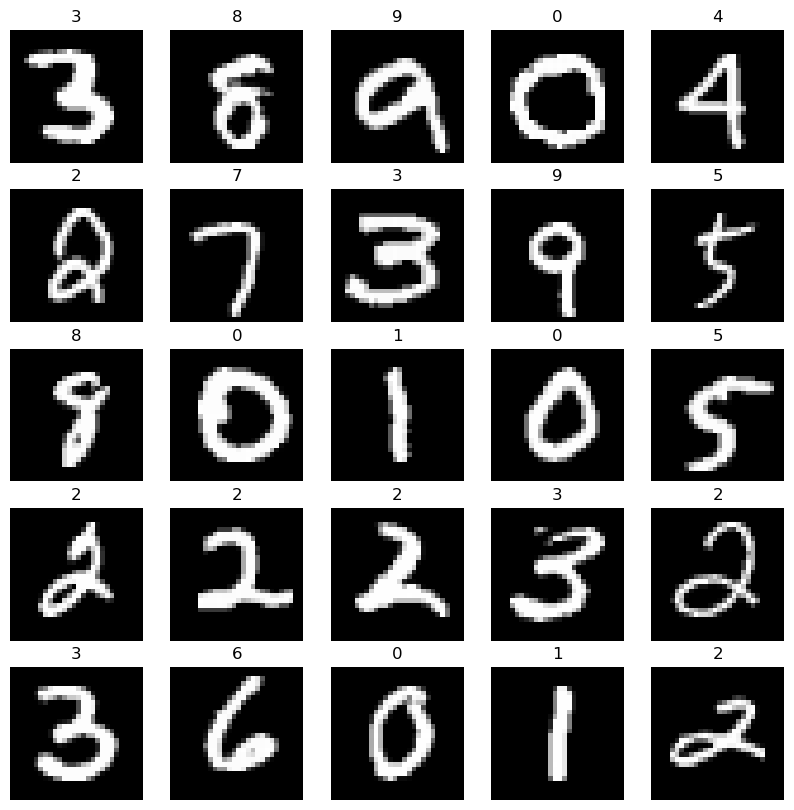

In [10]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.ravel()
images, labels = next(iter(test_loader))
images, labels = images[:25], labels[:25]
images = images.to(device)
y_pred_ = modelc(images)
label_pred = torch.argmax(y_pred_, dim=1)
images = images.to('cpu')
for i, (im, label) in enumerate(zip(images, labels)):
    axes[i].imshow(im.reshape((28,28)), cmap='gray')
    axes[i].set_title(label_pred[i].item())
    axes[i].axis('off')

plt.show()

In [11]:
y_pred, y_true = torch.tensor(y_pred), torch.tensor(y_true)
base_acc = accuracy(y_pred, y_true)
base_acc

0.9882

# Regression model

In [12]:
class RegressionModel(nn.Module):
    '''model stolen from https://www.kaggle.com/code/alien2327/simple-cnn-classification-mnist'''
    def __init__(self):
        super().__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.seq2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.seq3 = nn.Sequential(
            nn.Linear(7*7*64, 32, bias=True),
            nn.ELU(inplace=True),
            nn.Linear(32, 1, bias=True)
        )
        
    def forward(self, x):
        x = self.seq1(x)
        x = self.seq2(x)
        x = x.view(x.size(0), -1)
        x = self.seq3(x)
        x = x.view(-1)
        return x
    
modelr = RegressionModel()
modelr = modelr.to(device)

criterionr = nn.MSELoss().to(device)
optimizerr = torch.optim.Adam(modelr.parameters(), lr=0.001)

In [13]:
history = []
if not os.path.exists('models/modelr.pth'):
    EPOCH = 50
    modelr.train()
    for epoch in tqdm(range(EPOCH)):
        loss_tmp = []
        for i, (image, label) in enumerate(train_loader):
            # TODO: add noise to the one-hot labels
            image, label = image.to(device), label.to(torch.float32).to(device)
            y_pred = modelr(image)
            loss = criterionr(y_pred, label)
            optimizerr.zero_grad()
            loss.backward()
            optimizerr.step()
            loss_tmp.append(loss.item())
        history.append(np.mean(loss_tmp))
        print(f"\rEPOCH: [{epoch+1}/{EPOCH}], LOSS: {history[-1]:1.6f}", end="")
    torch.save(modelr.state_dict(), 'models/modelr.pth')
else:
    checkpoint = torch.load('models/modelr.pth')
    modelr.load_state_dict(checkpoint)

In [14]:
if history:
    plt.plot(history, label="MSE Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [15]:
modelr.eval()
y_pred = []
y_true = []
for i, (image, label) in enumerate(test_loader):
    image = image.to(device)
    y_pred_ = modelr(image)
    y_pred.append(y_pred_.cpu().tolist())
    y_true.append(label.cpu().tolist())
y_pred, y_true = flatten_list(y_pred), flatten_list(y_true)

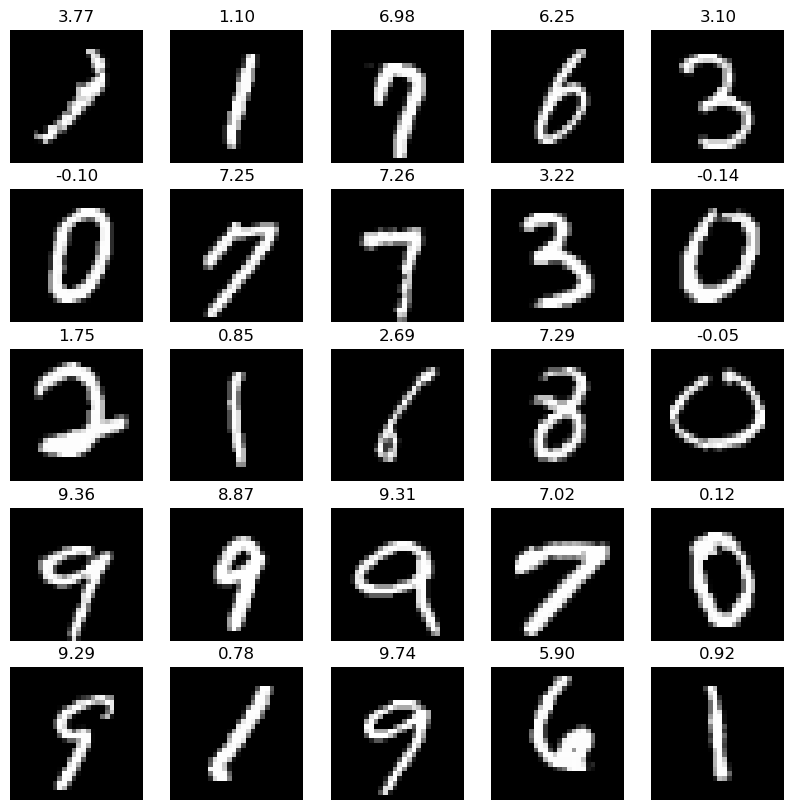

In [16]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.ravel()
images, labels = next(iter(test_loader))
images, labels = images[:25], labels[:25]
images = images.to(device)
y_pred_ = modelr(images)
images = images.to('cpu')
for i, (im, label) in enumerate(zip(images, labels)):
    axes[i].imshow(im.reshape((28,28)), cmap='gray')
    axes[i].set_title(f'{y_pred_[i].item():.2f}')
    axes[i].axis('off')

plt.show()

In [17]:
y_pred, y_true = torch.tensor(y_pred, dtype=float), torch.tensor(y_true, dtype=float)
base_MSE = MSE(y_pred, y_true)
base_MSE

0.24312291934019942

# Apply the Laplacian mechanism after training
(I believe this is the wrong way of doing it)

In [18]:
epsilons = np.logspace(-3, 3, 10) # n epsilons in [min, max]
sensitivities = {'regression': 9, # (n_labels - 1) = 9
                 'classification': 2 # e.g. two different one-hot encoded
                # numbers will have the difference 000000001 - 000000100 = 2
                 }

## To the Classification model

In [19]:
accuracies = []
for epsilon in epsilons:
    sensitivity = sensitivities['classification']
    scale = sensitivity / epsilon
    L = Laplace(loc=0, scale=scale)

    y_pred = []
    y_true = []
    modelc.eval()
    for i, (image, label) in enumerate(test_loader):
        image = image.to(device)
        y_pred_ = modelc(image)
        label_pred = torch.argmax(y_pred_, dim=1)
        y_pred.append(label_pred.cpu().tolist())
        label = label.cpu()
        noise_c = L.sample([100])
        label = torch.round(label + noise_c)
        y_true.append(label.tolist())
    y_pred, y_true = flatten_list(y_pred), flatten_list(y_true)

    y_pred, y_true = torch.tensor(y_pred), torch.tensor(y_true)
    accuracies.append(accuracy(y_pred, y_true))

## To the Regression model

In [20]:
MSEs = []
for epsilon in epsilons:
    sensitivity = sensitivities['regression']
    scale = sensitivity / epsilon
    L = Laplace(loc=0, scale=scale)

    modelr.eval()
    y_pred = []
    y_true = []
    for i, (image, label) in enumerate(test_loader):
        image = image.to(device)
        y_pred_ = modelr(image)
        y_pred.append(y_pred_.cpu().tolist())
        label = label.cpu()
        noise_r = L.sample([100])
        label = label + noise_r
        y_true.append(label.tolist())
    y_pred, y_true = flatten_list(y_pred), flatten_list(y_true)
    y_pred, y_true = torch.tensor(y_pred, dtype=float), torch.tensor(y_true, dtype=float)
    MSEs.append(MSE(y_pred, y_true))

## Visualisation

plots showing the performance trade-off (Respectively accuracy and MSE vs. $\epsilon$)

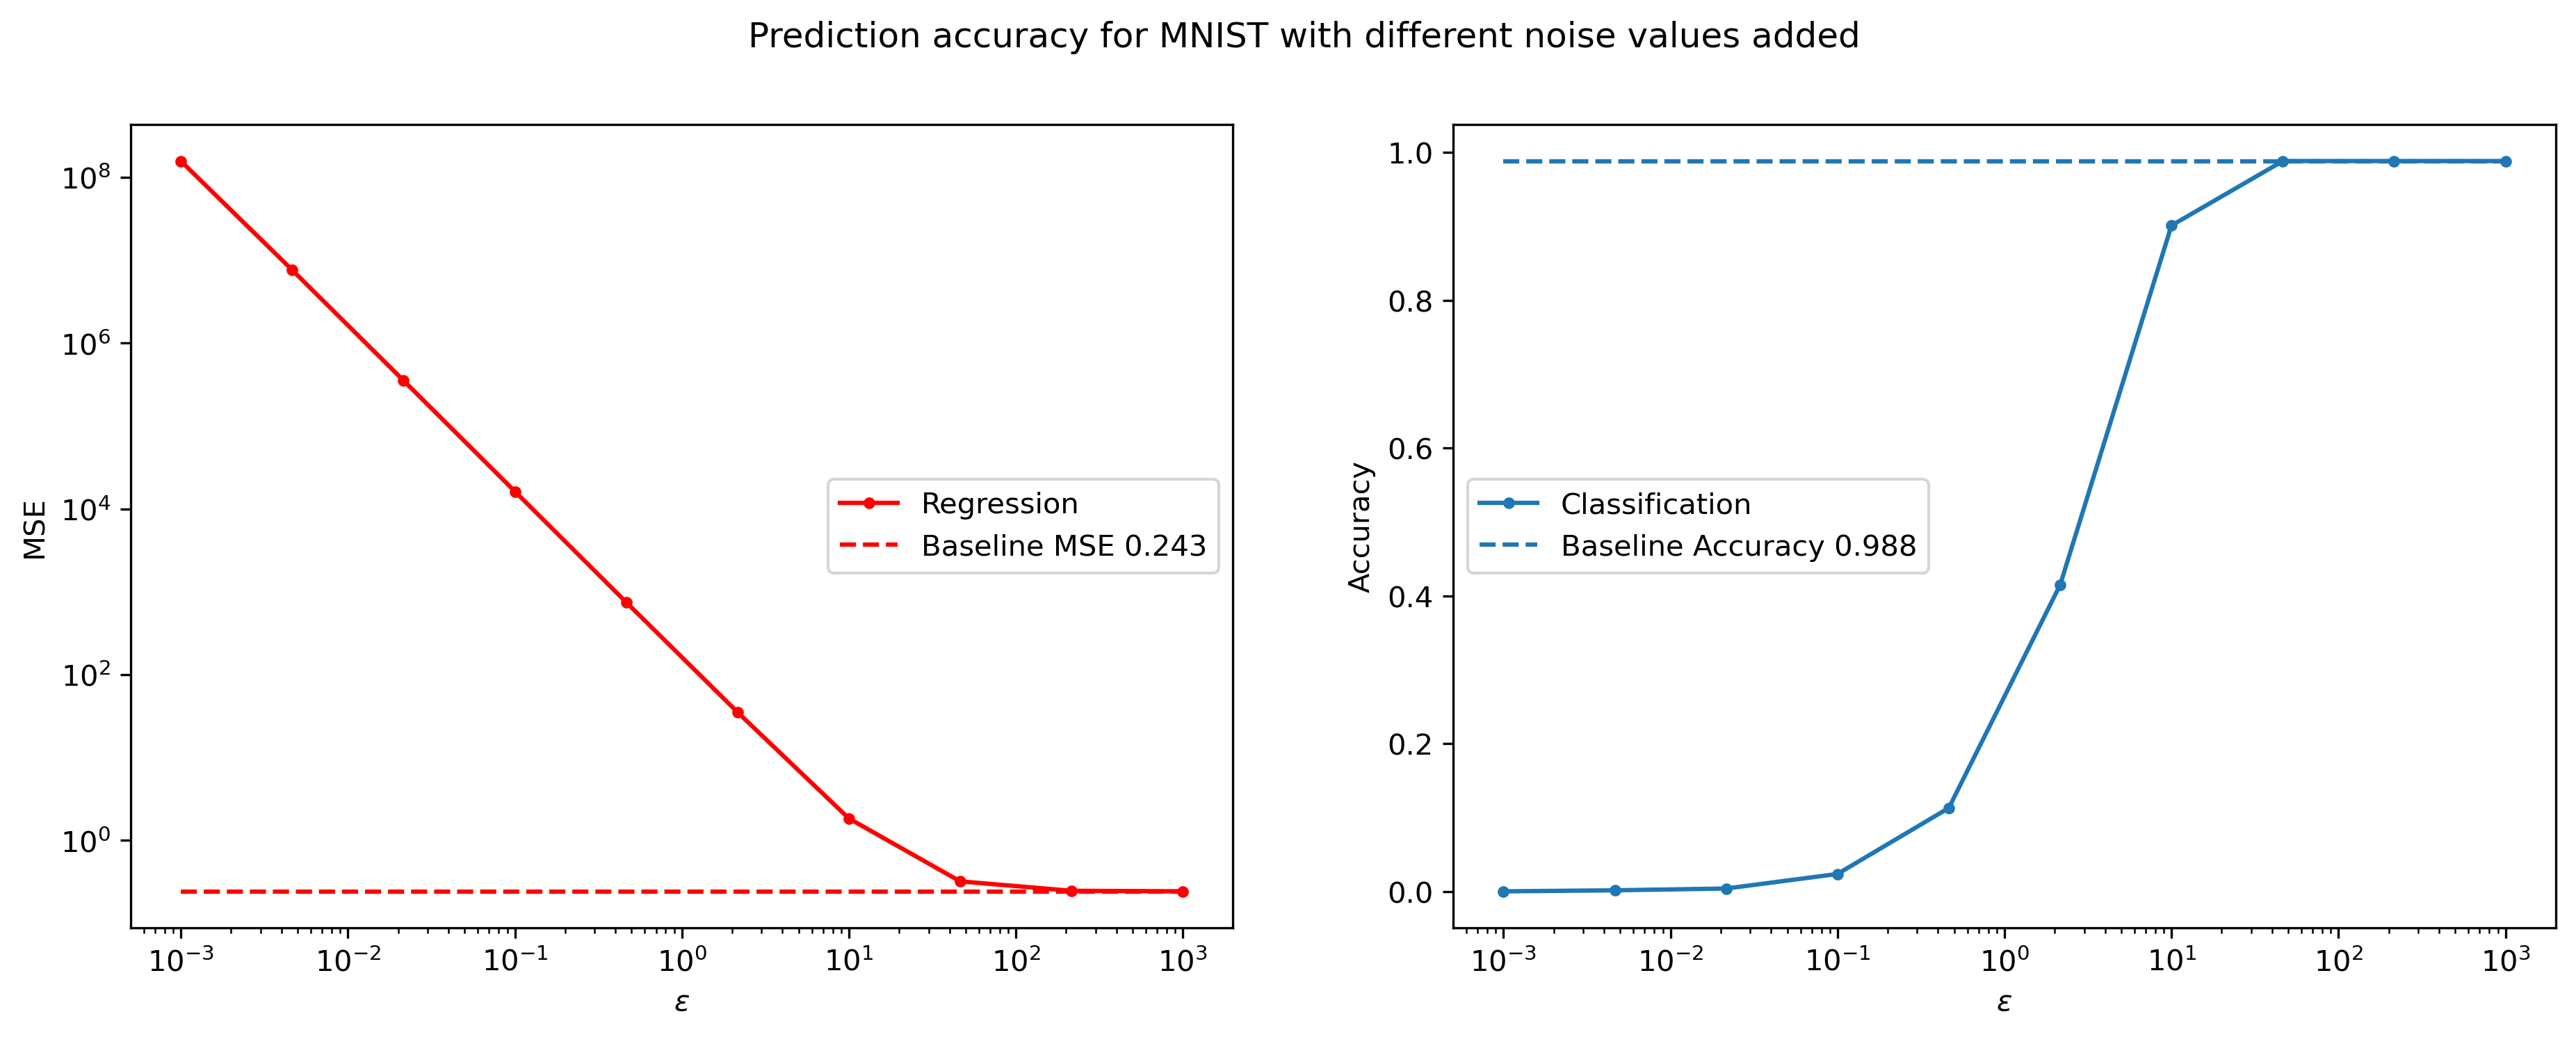

In [21]:
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(15,5))

fig.suptitle('Prediction accuracy for MNIST with different noise values added')

axs[0].loglog(epsilons, MSEs, '.-', color='r', label='Regression')
axs[0].hlines(base_MSE, min(epsilons), max(epsilons), 'r', linestyles='--', label=f'Baseline MSE {base_MSE:.3f}')
axs[1].semilogx(epsilons, accuracies, '.-', label='Classification')
axs[1].hlines(base_acc, min(epsilons), max(epsilons), linestyles='--', label=f'Baseline Accuracy {base_acc:.3f}')
axs[0].legend(loc='center right')
axs[1].legend(loc='center left')
axs[0].set_ylabel('MSE')
axs[0].set_xlabel(r'$\epsilon$')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel(r'$\epsilon$');
plt.savefig('figs/noises.png',dpi=300)

# Apply Mechanism before training

## Classification model

In [22]:
# epsilons = np.linspace(0.5, 1, 6) # n epsilons in [min, max]
epsilons = np.logspace(-3, 3, 10)

In [23]:
accuracies = []
for epsilon in epsilons:
    sensitivity = sensitivities['classification']
    scale = sensitivity / epsilon
    L = Laplace(loc=0, scale=scale)
    history_c = []
    EPOCH = 40
    modelc.train()
    for epoch in tqdm(range(EPOCH)):
        loss_tmp = []
        for i, (image, label) in enumerate(train_loader):
            image, label = image.to(device), label.to(device)
            # add the noise
            noise_c = L.sample([100]).to(device)
            a = (label.type(torch.cuda.LongTensor)).to(device) + noise_c
            label = torch.round(a)
            label = torch.clamp(label, min=0, max=9).type(torch.cuda.LongTensor)

            y_pred = modelc(image)
            loss = criterionc(y_pred, label)
            optimizerc.zero_grad()
            loss.backward()
            optimizerc.step()
            loss_tmp.append(loss.item())
        history_c.append(np.mean(loss_tmp))
        print(f"\rEPOCH: [{epoch+1}/{EPOCH}], LOSS: {history_c[-1]:1.6f}", end="")
    torch.save(modelc.state_dict(), f'models/modelc_eps_{epsilon}.pth')

    y_pred = []
    y_true = []
    modelc.eval()
    for i, (image, label) in enumerate(test_loader):
        image = image.to(device)
        y_pred_ = modelc(image)
        label_pred = torch.argmax(y_pred_, dim=1)
        y_pred.append(label_pred.cpu().tolist())
        y_true.append(label.tolist())
    y_pred, y_true = flatten_list(y_pred), flatten_list(y_true)

    y_pred, y_true = torch.tensor(y_pred), torch.tensor(y_true)
    accuracies.append(accuracy(y_pred, y_true))


  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 0.712426

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 0.756362

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 0.925380

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 1.402297

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 2.094340

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 2.299704

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 2.301653

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 2.301450

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 2.301453

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 2.301476

## Regression model

In [24]:
MSEs = []
for epsilon in epsilons:
    sensitivity = sensitivities['regression']
    scale = sensitivity / epsilon
    L = Laplace(loc=0, scale=scale)
    history_r = []
    EPOCH = 40
    modelr.train()
    for epoch in tqdm(range(EPOCH)):
        loss_tmp = []
        for i, (image, label) in enumerate(train_loader):
            image, label = image.to(device), label.to(device)
            # add the noise
            noise_c = L.sample([100]).to(device)
            label = (label.type(torch.cuda.FloatTensor)).to(device) + noise_c
            # label = torch.round(a)
            label = torch.clamp(label, min=0, max=9).type(torch.cuda.FloatTensor)

            y_pred = modelr(image)
            loss = criterionr(y_pred, label)
            optimizerr.zero_grad()
            loss.backward()
            optimizerr.step()
            loss_tmp.append(loss.item())
        history_r.append(np.mean(loss_tmp))
        print(f"\rEPOCH: [{epoch+1}/{EPOCH}], LOSS: {history_r[-1]:1.6f}", end="")
    torch.save(modelr.state_dict(), f'models/modelr_eps_{epsilon}.pth')
    
    y_pred = []
    y_true = []
    modelr.eval()
    for i, (image, label) in enumerate(test_loader):
        image = image.to(device)
        y_pred_ = modelr(image)
        y_pred.append(y_pred_.cpu().tolist())
        label = label.cpu()
        y_true.append(label.tolist())
    y_pred, y_true = flatten_list(y_pred), flatten_list(y_true)
    y_pred, y_true = torch.tensor(y_pred, dtype=float), torch.tensor(y_true, dtype=float)
    MSEs.append(MSE(y_pred, y_true))

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 20.251584

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 20.229411

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 20.115410

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 19.624443

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 17.560826

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 12.193558

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 8.534954

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 8.255257

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 8.318671

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: [40/40], LOSS: 8.344683

## Visualisation

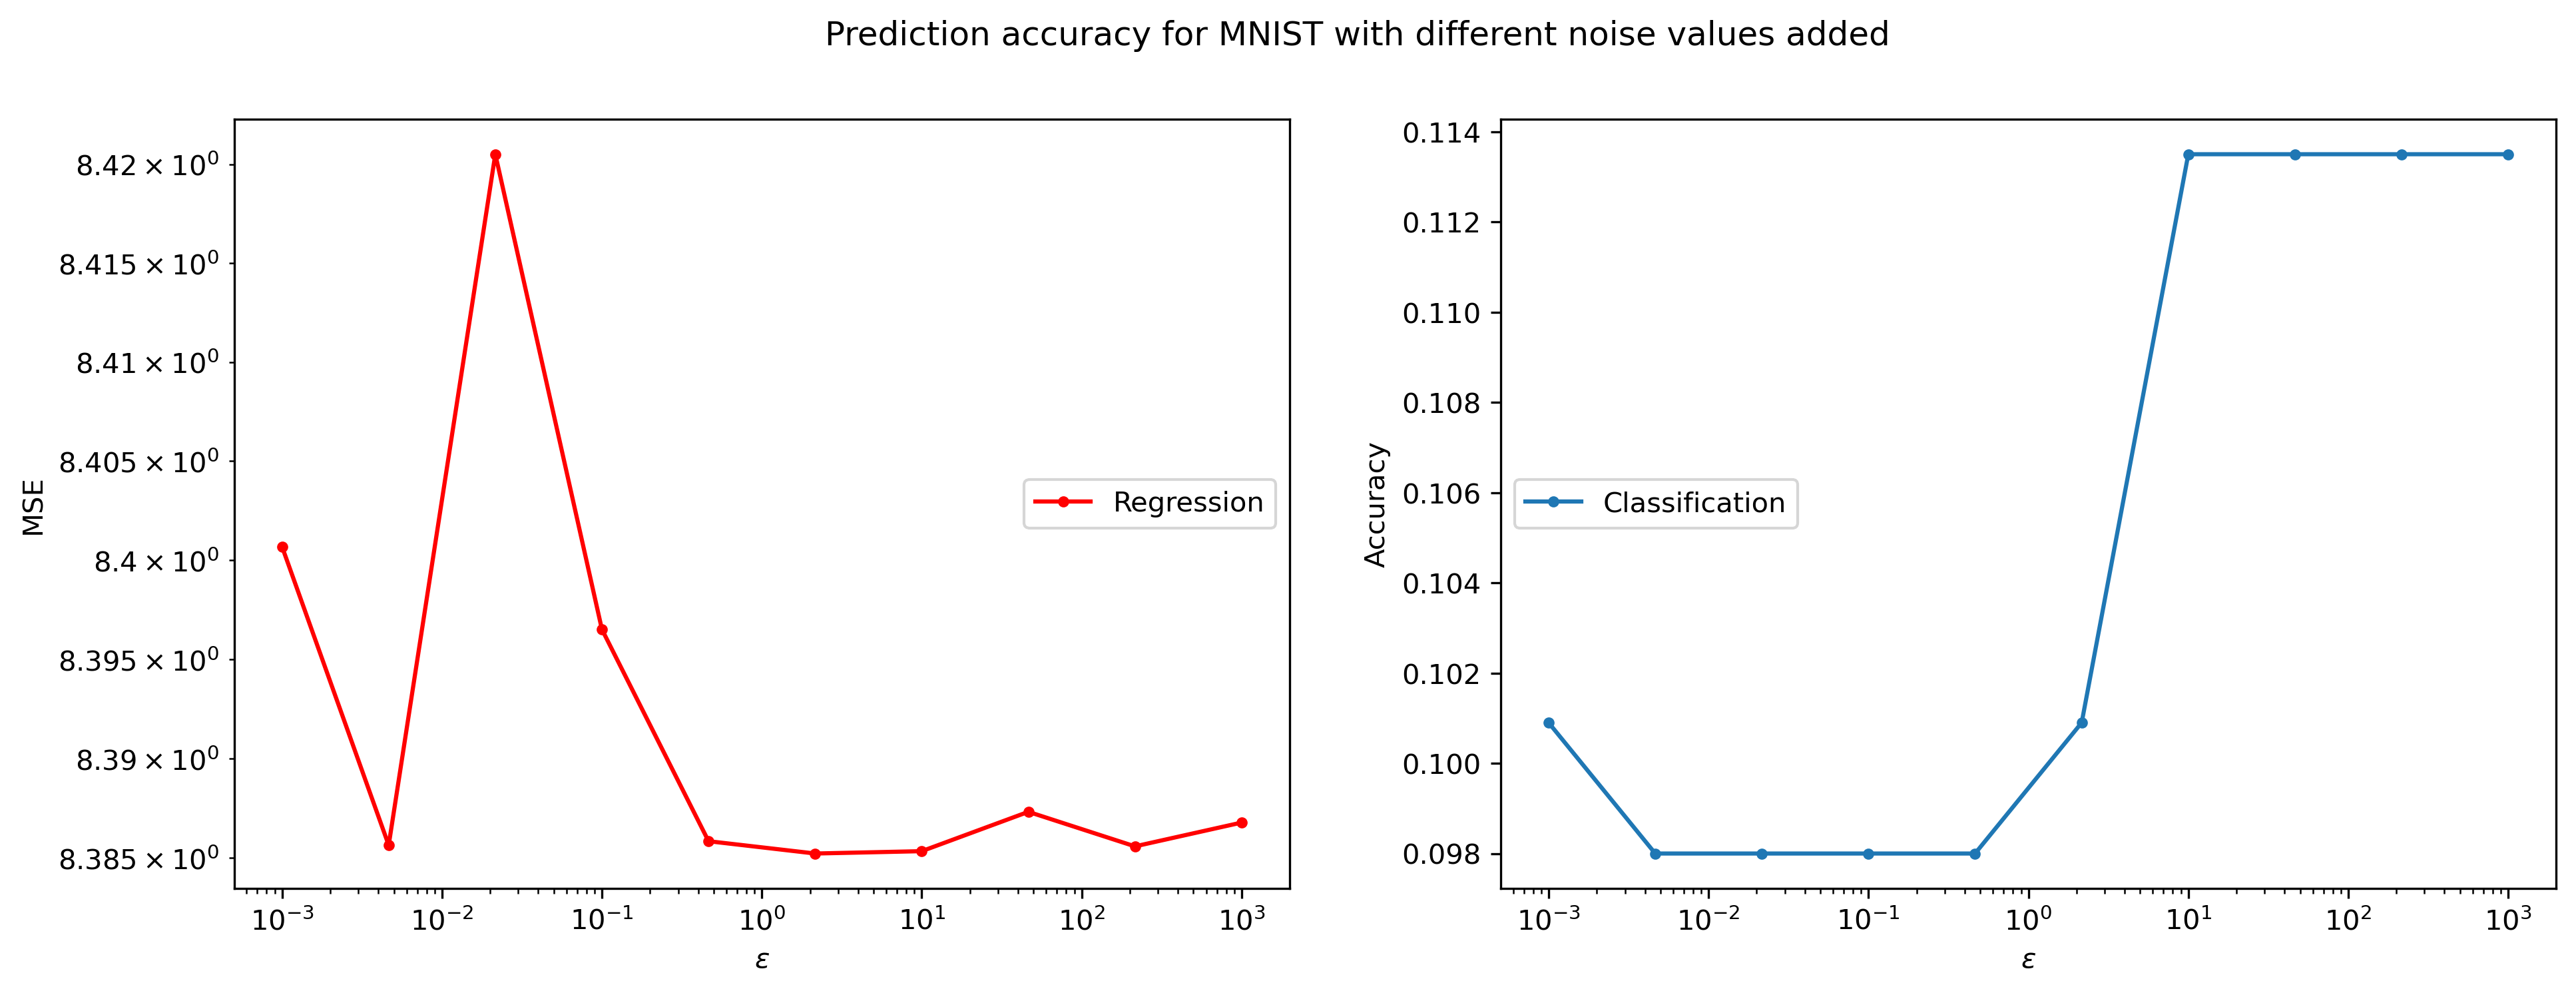

In [26]:
fig, axs = plt.subplots(1, 2, dpi=300, figsize=(15,5))

fig.suptitle('Prediction accuracy for MNIST with different noise values added')

axs[0].loglog(epsilons, MSEs, '.-', color='r', label='Regression')
# axs[0].hlines(base_MSE, min(epsilons), max(epsilons), 'r', linestyles='--', label=f'Baseline MSE {base_MSE:.3f}')
axs[1].semilogx(epsilons, accuracies, '.-', label='Classification')
# axs[1].hlines(base_acc, min(epsilons), max(epsilons), linestyles='--', label=f'Baseline Accuracy {base_acc:.3f}')
axs[0].legend(loc='center right')
axs[1].legend(loc='center left')
axs[0].set_ylabel('MSE')
axs[0].set_xlabel(r'$\epsilon$')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel(r'$\epsilon$');
plt.savefig('figs/noises_pretrain.png',dpi=300)